# Implementation of "Fair Decisions Despite Imperfect Predictions" using the covariance fairness constraint

In [1]:
import numpy as np
from src.consequential_learning import collect_data, train
from src.feature_map import IdentityFeatureMap

## The parameters used by the the original authors  

In [2]:
training_parameters = {
    'dim_x': 1,
    'dim_s': 1,
    'time_steps':200,
    'batch_size':512,
    'num_iterations': 32,
    'learning_parameters': {
        'learning_rate': 0.5,
        'decay_rate': 0.8,
        'decay_step': 30
    },
    'fairness_rate':0.5,
    'cost_factor':0.55,
    'fraction_protected':0.3
}
training_parameters['dim_theta'] = training_parameters['dim_x'] + training_parameters['dim_s']
training_parameters['feature_map'] = IdentityFeatureMap(training_parameters['dim_theta'])
training_parameters['num_decisions'] = training_parameters['num_iterations'] * training_parameters['batch_size']

## Definition of the fairness function  
The covariance fairness constraint is defined as the covariance between the sensitive attribute and the signed distance from the users feature vectors to the decision boundary: $$Cov_{DI}(s, d_{\theta}) = E[(s - \mu_s)e]$$

In [3]:
def fairness_function(**fairness_kwargs):
    x = fairness_kwargs['x']
    s = fairness_kwargs['s']
    sample_theta = fairness_kwargs['sample_theta']
    policy = fairness_kwargs['policy']
    gradient = fairness_kwargs['gradient']

    ips_weight, phi, log_gradient_denominator = policy.calculate_ips_weights_and_log_gradient(x, s, sample_theta)
    decision = policy(x, s).reshape(-1, 1)

    mu_s = (ips_weight * s).mean(axis=0)
    covariance = (s - mu_s) * decision

    if gradient:
        grad_benefit = ((ips_weight/log_gradient_denominator) * covariance * phi).sum(axis=0) / x.shape[0]
        return grad_benefit
    else:
        benefit = (ips_weight * covariance).sum(axis=0) / x.shape[0]
        return benefit


## Train the model

In [10]:
i = 1
utilities = []
benefit_deltas = []

for utility, benefit_delta in train(**training_parameters, fairness_function=fairness_function):
    #print("Time step {}: Utility {} \n\t Benefit Delta {}".format(i, utility, benefit_delta))
    utilities.append(utility)
    benefit_deltas.append(benefit_delta)
    i += 1

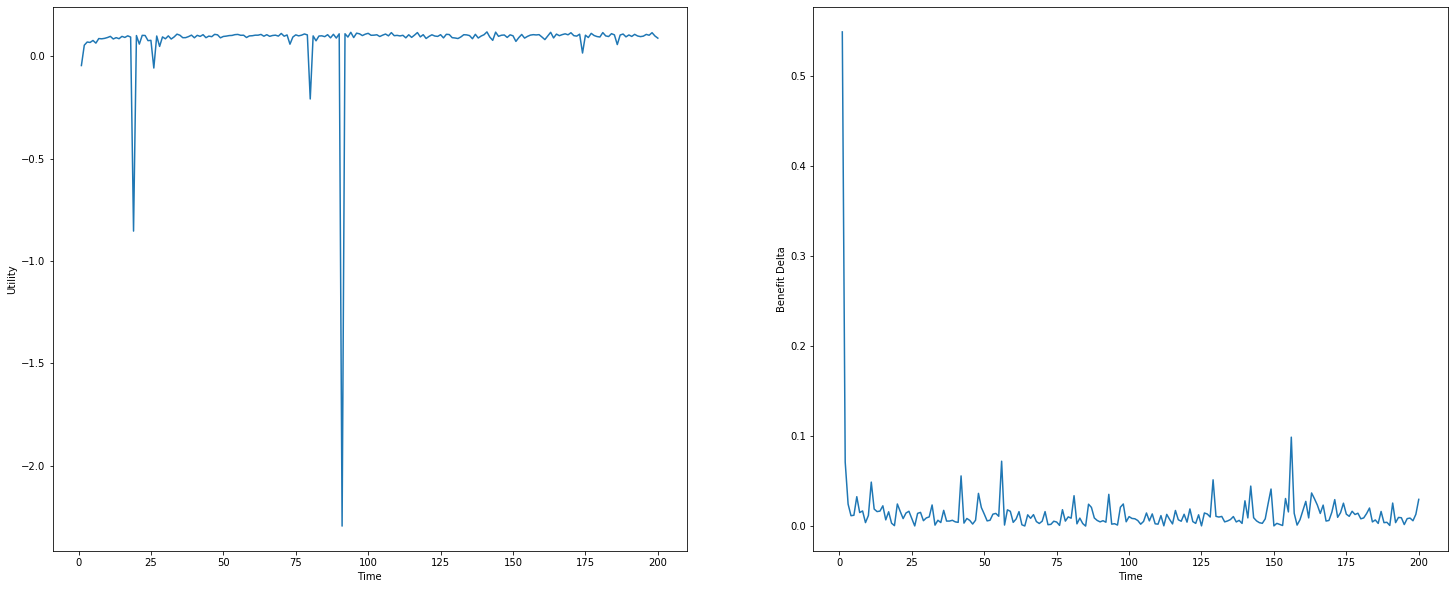

In [11]:
import matplotlib.pyplot as plt

f, (ax1, ax2) = plt.subplots(1, 2, sharex=True, figsize=(25,10))
ax1.plot(range(1, len(utilities) + 1), utilities)
ax1.set_xlabel("Time")
ax1.set_ylabel("Utility")
ax2.plot(range(1, len(benefit_deltas) + 1), benefit_deltas)
ax2.set_xlabel("Time")
ax2.set_ylabel("Benefit Delta")
plt.show()